# Assignment 2 For Clustering: Sessa Empirical Estimator
- Read the Journals about the Sessa Empirical Estimator.

- Convert the R codes into Python Codes (use jupyter notebook).

- Using Simulated data or a real world datasets of your choice, perform the Sessa Empircal Estimator and generate some insights.
    - https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2019.00383/full
    - https://archive.ics.uci.edu/

- The Sessa Empirical Estimator uses K-Means clustering (again recall the disadvantages of K-Means), try to substitute a different clustering algorithm, generate a new insight using the new clustering algorithm.

- Compare your results between Sessa Empirical Estimator using K-Means, and Sessa Empirical Estimator using the clustering algorithm of your choice.

- Deadline is this Sunday, Feb 23, 2022 at 11:59 pm

- Do this with your thesis partner.

- You can use any A.I. assistant.

#### Import equivalent libraries from R to Python

In [ ]:
library(AdhereR)
library(dplyr)
library(plyr)
library(lubridate)
library(latticeExtra)
library(data.table)
library(factoextra)
library(stats)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import norm
from sklearn import decomposition, preprocessing
from scipy.stats import ecdf
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns
from IPython.display import display

#### Convert and generate simulated data from article provided (NO LONGER THE DATA SET USED)
- https://github.com/Masswear/BeyondThresholds/blob/master/Code/functions.R

- Asked GPT for the equivalent R functions in Python
    - i.e what in the world qnorm() is

In [3]:
np.random.seed(42)

def logistics(x, L=0, S=1, D=1, h=1, B=None): #used in groups 4 and 5
    if B is None:
        B = x - D
    y = (h-(5*L))/(1 + np.exp(S*B)) + L
    return y

def med_events_sample(ntot, start_date="01.01.2022", tot_duration=2*365, disp_durations=[30, 60, 90], dist_durations=[0.3, 0.5, 0.2], dist=[0.1, 0.2, 0.2, 0.2, 0.2, 0.1]):
    def offset(group, n): #gives back an array of offset dates based on the group number of assigned patient
        if group == 1:
            L, U, m, s = -0.1, 0.2, 0.05, 0.1
            pL, pU = norm.cdf(L, m, s), norm.cdf(U, m, s)
            offset = norm.ppf(np.random.uniform(pL, pU, n), m, s)
        elif group == 2:
            L, U, m, s = -0.2, 1.2, 0, 1
            pL, pU = norm.cdf(L, m, s), norm.cdf(U, m, s)
            offset = norm.ppf(np.random.uniform(pL, pU, n), m, s)
        elif group == 3:
            L, U, m, s = 0.5, 1.5, 1, 1
            pL, pU = norm.cdf(L, m, s), norm.cdf(U, m, s)
            offset1 = norm.ppf(np.random.uniform(pL, pU, n), m, s)
            t = 2/n * np.arange(1, n+1)
            offset = t* offset1
        elif group == 4:
            L, U, m, s = 0.8, 1.2, 1, 0.1
            pL, pU = norm.cdf(L, m, s), norm.cdf(U, m, s)
            offset1 = norm.ppf(np.random.uniform(pL, pU, n), m, s)
            offset = logistics(x=np.arange(1, n+1), L=0.05, S=10, D=n, B=np.sin(2*np.arange(1, n+1)-n))*offset1
        elif group == 5:
            L, U, m, s = 0.5, 1.5, 1, 1
            pL, pU = norm.cdf(L, m, s), norm.cdf(U, m, s)
            offset1 = norm.ppf(np.random.uniform(pL, pU, n), m, s)
            offset = logistics(x=np.arange(1, n+1), L=0.05, S=-15, D=n/3)*offset1
        elif group == 6:
            n =  np.random.choice([2,3])
            L, U, m, s = -0.2, 0.8, 0.3, 1
            pL, pU = norm.cdf(L, m, s), norm.cdf(U, m, s)
            offset = norm.ppf(np.random.uniform(pL, pU, n), m, s)

        return offset

    def refills(x, group): #fills all entries of refill dates for 1 patient 
        initial_fill = 30
        offsets = offset(group=group, n=len(disp_durations))

        durations = np.random.choice(disp_durations, size=len(offsets)-1, replace=True, p=dist_durations)
        durations = np.insert(durations, 0, initial_fill)

        date = datetime.strptime(start_date, "%d.%m.%Y").date()

        refill_dates = [date] + [date + timedelta(days=int(sum(durations[:i+1]) + round(offsets[i] * durations[i], 0))) for i in range(len(durations))] #might be the cause of only 3 refill dates every patient

        medicine_type = np.random.choice(['Med_A', 'Med_B', 'Med_C'])

        df = pd.DataFrame({
            'GROUP': group,
            'PATIENT_ID': x, 
            'DATE': refill_dates[:-1],
            'DURATION': durations,
            'ATC' : medicine_type
        })
        

        return df

    ID_last = 0
    sample = pd.DataFrame()
    
    mean_duration = np.sum(np.array(disp_durations) * np.array(dist_durations))

    n = int(np.ceil((tot_duration/mean_duration) * 1.5))

    temp_samples = []

    for i in range(1, 6):
        num_pat = round(dist[i-1] * ntot) #this evenly spaces out the patients sequentially to each group, i think this should be changed to random
        ID_first = ID_last + 1
        ID_last = ID_first + num_pat - 1
        temp_groups = [refills(x, i) for x in range(ID_first, ID_last + 1)]
        temp_groups = [g for g in temp_groups if not g.empty]  # Remove empty DataFrames

        if temp_groups:
            group = pd.concat(temp_groups)
            temp_samples.append(group)

    num_pat = ntot - ID_last
    ID_first = ID_last + 1
    ID_last = ID_first + num_pat - 1
    temp_groups = [refills(x, 6) for x in range(ID_first, ID_last + 1)] #meant to assign any leftovers to group6
    temp_groups = [g for g in temp_groups if not g.empty] 

    if temp_groups: 
        group = pd.concat(temp_groups) 
        temp_samples.append(group)
        sample.reset_index(drop=True, inplace=True)
        
    if temp_samples:
        sample = pd.concat(temp_samples)
        sample.reset_index(drop=True, inplace=True)

    if sample.empty:
        print("No data was generated!")
    else:
        display(sample)
        # sample.to_csv("med_events_sample.csv", index=False)
        # print("CSV file saved: med_events_sample.csv")

if __name__ == "__main__":
    ntot = 100  # Example number of patients
    med_events_sample(ntot)

,GROUP,PATIENT_ID,DATE,DURATION,ATC
0,1,1,2022-01-01,30,Med_C
1,1,1,2022-02-01,60,Med_C
2,1,1,2022-04-11,30,Med_C
3,1,2,2022-01-01,30,Med_A
4,1,2,2022-01-29,30,Med_A
...,...,...,...,...,...
291,6,98,2022-05-17,60,Med_C
292,6,99,2022-01-01,30,Med_C
293,6,99,2022-02-07,60,Med_C
294,6,100,2022-01-01,30,Med_B


### Dataset used for the code below
- Note that the data set used for the succeeding portions of code comes from the link provided and not the one generated above as advised by the instructor.
- https://rdrr.io/cran/AdhereR/man/med.events.html

In [4]:
df = pd.read_csv("med_events.csv")
display(df)

,PATIENT_ID,DATE,PERDAY,CATEGORY,DURATION
0,1,04/26/2033,4,medA,50
1,1,07/04/2033,4,medB,30
2,1,08/03/2033,4,medB,30
3,1,08/17/2033,4,medB,30
4,1,10/13/2033,4,medB,30
...,...,...,...,...,...
1075,100,03/05/2034,6,medB,30
1076,100,04/07/2034,6,medB,30
1077,100,04/26/2034,6,medB,30
1078,100,05/26/2034,6,medB,30


### Converting the Sessa Empirical Estimation from R to Python
- See the SEE.R file found in the same directory

C:\Users\Rhenz\AppData\Local\Temp\ipykernel_13472\2760009238.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_see_p1 = (df_see_p1.groupby("PATIENT_ID", group_keys=False).apply(lambda x: x.sample(1, random_state= 42)).reset_index(drop=True))


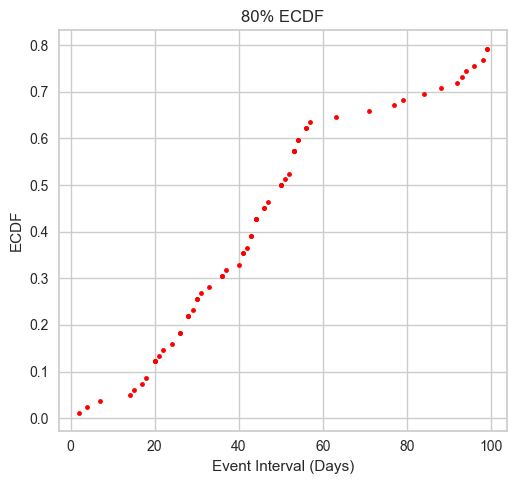

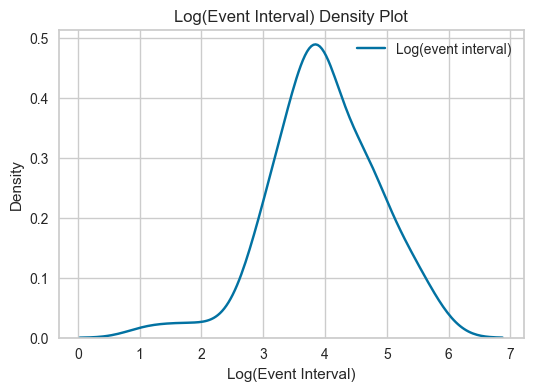

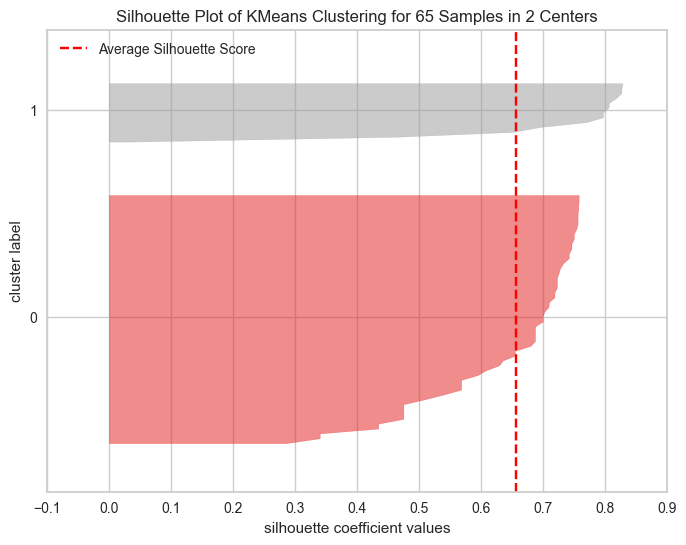

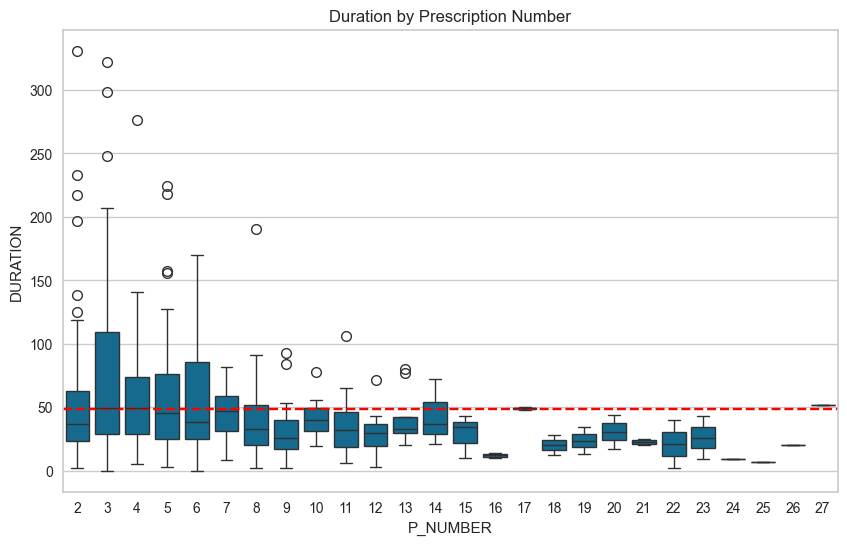

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import norm
from sklearn import decomposition, preprocessing
from scipy.stats import ecdf
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns
from IPython.display import display

def load_and_preprocess_data(filepath, med_type):
    
    df = pd.read_csv(filepath)
    df["DATE"] = pd.to_datetime(df["DATE"])
    df_filtered = df[df["CATEGORY"] == med_type].copy()

    df_see_p0: pd.DataFrame = df_filtered.copy()
    df_see_p1: pd.DataFrame = df_filtered.copy()

    df_see_p1 = df_see_p1.sort_values(by=["PATIENT_ID", "DATE"])  
    df_see_p1["PREV_DATE"] = df_see_p1.groupby("PATIENT_ID")["DATE"].shift(1) 
    df_see_p1 = df_see_p1.dropna(subset=["PREV_DATE"])
    
    df_see_p1["EVENT_INTERVAL"] = (df_see_p1["DATE"] - df_see_p1["PREV_DATE"]).dt.days
    
    df_see_p1 = (df_see_p1.groupby("PATIENT_ID", group_keys=False).apply(lambda x: x.sample(1, random_state= 42)).reset_index(drop=True))
    
    return df_see_p1, df_see_p0

def plot_ecdf(df_see_p1):

    ecdf_vals = ecdf(df_see_p1["EVENT_INTERVAL"])
    x = np.sort(df_see_p1["EVENT_INTERVAL"])
    y = ecdf_vals.cdf.evaluate(x)

    df_ecdf = pd.DataFrame({"x": x, "y": y})
    
    # Retain 80% of the ECDF
    df_ecdf = df_ecdf[df_ecdf["y"] <= 0.8]
    
    # Plot 80%
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(df_ecdf["x"], df_ecdf["y"], marker=".", linestyle="none", color="red")
    plt.xlabel("Event Interval (Days)")
    plt.ylabel("ECDF")
    plt.title("80% ECDF")
      
    plt.tight_layout()
    plt.show()
    
    return df_ecdf

def plot_density(df_see_p1):
    #theres no replacing 0 with 1s for event interval to avoid log(0)
    log_intervals = np.log1p(df_see_p1["EVENT_INTERVAL"])
    
    plt.figure(figsize=(6, 4))
    sns.kdeplot(log_intervals, label="Log(event interval)")
    plt.xlabel("Log(Event Interval)")
    plt.ylabel("Density")
    plt.title("Log(Event Interval) Density Plot")
    plt.legend()
    plt.show()

    return log_intervals

def assign_clusters(df_ecdf):
    
    X = df_ecdf[["x"]].values
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    best_k = None
    best_score = -1
    cluster_range = range(2, 11)
    
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=1234)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        
        if score > best_score:
            best_k = k
            best_score = score
    
    kmeans = KMeans(n_clusters=best_k, random_state=1234)
    df_ecdf["CLUSTER"] = kmeans.fit_predict(X)

    fig, ax = plt.subplots(figsize=(8, 6))
    visualizer = SilhouetteVisualizer(kmeans, ax=ax)
    visualizer.fit(X)
    visualizer.show()
    
    return df_ecdf

def statistics(df_ecdf):
    stats = df_ecdf.groupby("CLUSTER")["x"].agg(["min", "max", "median"])
    stats = stats.reset_index()
    stats.columns = ['CLUSTER_NO', 'MINIMUM', 'MAXIMUM', "MEDIAN"]
    return stats

def merge_results(stats, df_see_p0, df_see_p1):

    results = pd.merge(df_see_p1, stats, how="cross")
    results["FINAL_CLUSTER"] = np.where((results["EVENT_INTERVAL"]>= results["MINIMUM"]) & (results["EVENT_INTERVAL"] <= results["MAXIMUM"]), results["CLUSTER_NO"], np.nan)
    results = results.dropna(subset=["FINAL_CLUSTER"])

    most_freq = results["CLUSTER_NO"].value_counts().idxmax()
    most_freq_merged = results[results["CLUSTER_NO"] == most_freq].iloc[0]

    # Merge results with df_see_p1
    df_see_p1 = pd.merge(df_see_p1, results[["PATIENT_ID", "MEDIAN", "CLUSTER_NO"]], on="PATIENT_ID", how="left")

    # Fill missing values in MEDIAN
    df_see_p1["MEDIAN"] = df_see_p1["MEDIAN"].fillna(most_freq_merged["MEDIAN"])

    # Add CLUSTER column by copying CLUSTER_NO , will change cuz thats dumb
    df_see_p1["CLUSTER"] = df_see_p1["CLUSTER_NO"].fillna(0)  # Fix: Add CLUSTER column

    # Compute TEST
    df_see_p1["TEST"] = df_see_p1["EVENT_INTERVAL"] - df_see_p1["MEDIAN"]

    

    df_see_p0 = pd.merge(df_see_p0, df_see_p1[["PATIENT_ID", "MEDIAN", "CLUSTER_NO"]], on="PATIENT_ID", how="left")
    df_see_p0["MEDIAN"] = df_see_p0["MEDIAN"].fillna(most_freq_merged["MEDIAN"])
    df_see_p0["CLUSTER_NO"] = df_see_p0["CLUSTER_NO"].fillna(0)

    return df_see_p0

def box_and_whiskers(df_see_p0):
    df_see_p0 = df_see_p0.sort_values(by=["PATIENT_ID", "DATE"])
    df_see_p0["PREV_DATE"] = df_see_p0.groupby("PATIENT_ID")["DATE"].shift(1)

    final_df = df_see_p0.copy()
    final_df["P_NUMBER"] = final_df.groupby("PATIENT_ID").cumcount() + 1
    final_df = final_df[final_df["P_NUMBER"] >= 2]
    final_df = final_df[["PATIENT_ID", "DATE", "PREV_DATE", "P_NUMBER"]]
    final_df["DURATION"] = (final_df["DATE"] - final_df["PREV_DATE"]).dt.days

    # Boxplot with medians
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="P_NUMBER", y="DURATION", data=final_df)
    
    medians_of_medians = final_df.groupby("PATIENT_ID")["DURATION"].median().reset_index()
    plt.axhline(y=medians_of_medians["DURATION"].median(), color="red", linestyle="--")
    plt.title("Duration by Prescription Number")
    plt.show()

def main():
    filepath = "med_events.csv"
    med_type = "medB"

    df_see_p1, df_see_p0 = load_and_preprocess_data(filepath, med_type)

    df_ecdf = plot_ecdf(df_see_p1)

    density_plot = plot_density(df_see_p1)

    df_ecdf = assign_clusters(df_ecdf)

    stats = statistics(df_ecdf)

    df_see_p0 = merge_results(stats, df_see_p0, df_see_p1) 

    box_and_whiskers(df_see_p0)

    return df_see_p0

if __name__ == "__main__":
    final_df = main()


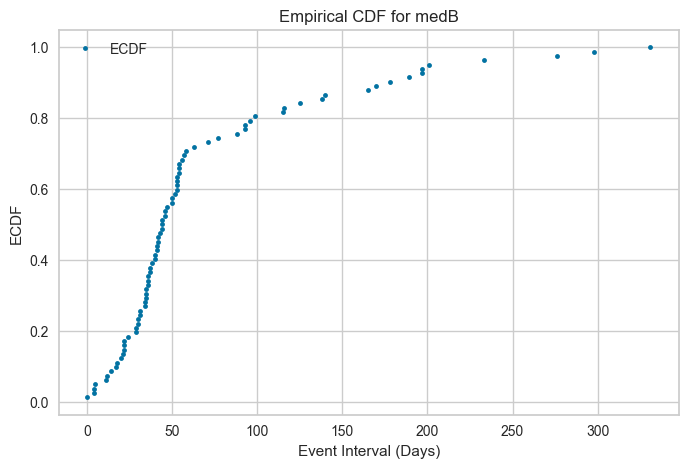

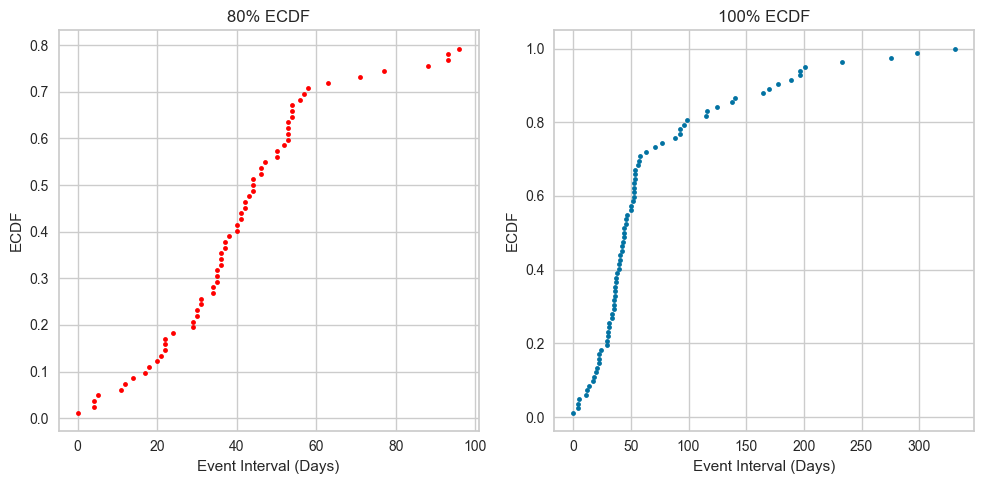

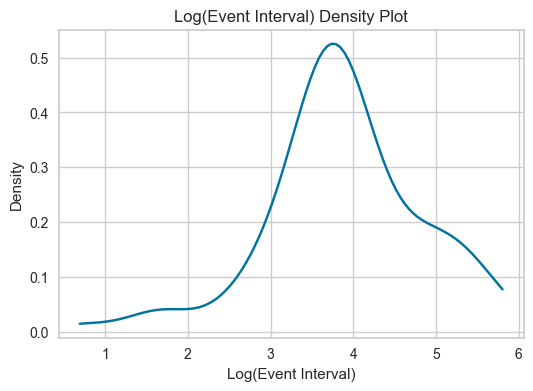

Optimal number of clusters: 3, Silhouette Score: 0.6396


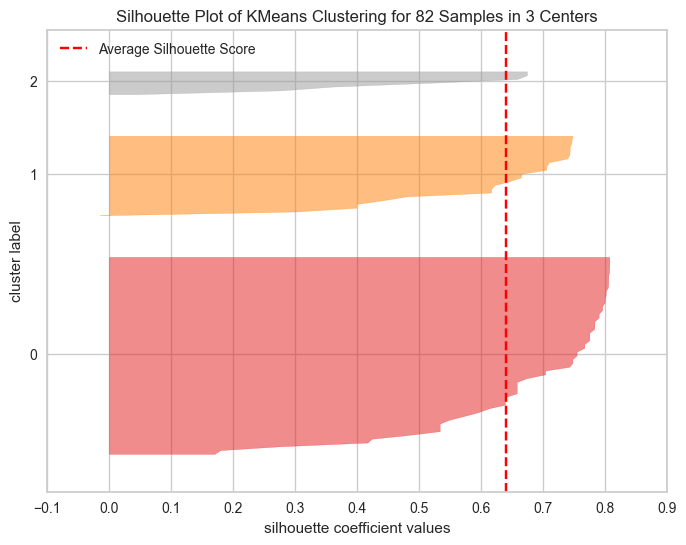

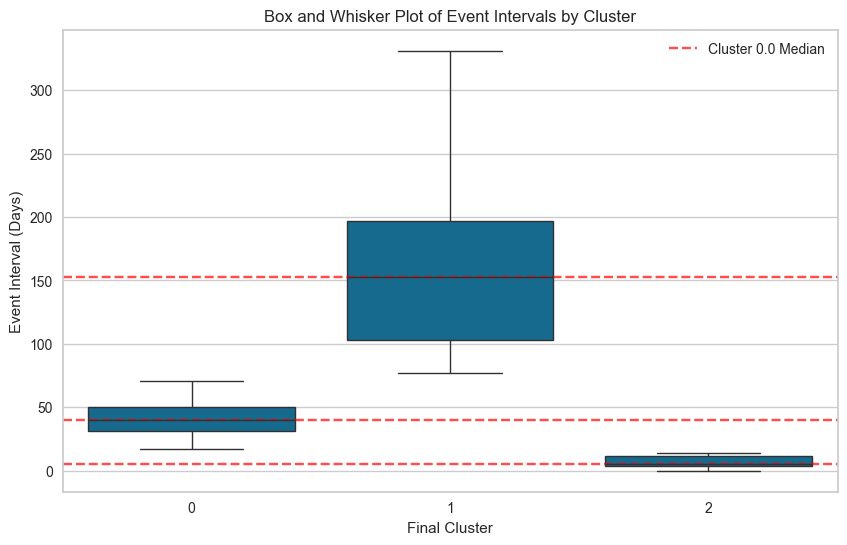

In [36]:
# Step 1: Load and preprocess data
def load_and_preprocess_data(filepath, med_type):
    # Load the dataset
    df = pd.read_csv(filepath)
    
    # Convert DATE column to datetime
    df["DATE"] = pd.to_datetime(df["DATE"])
    
    # Filter data for the specified medication type
    df_filtered = df[df["CATEGORY"] == med_type].copy()
    
    # Sort by PATIENT_ID and DATE
    df_filtered = df_filtered.sort_values(by=["PATIENT_ID", "DATE"])
    
    # Compute previous visit date for each patient
    df_filtered["PREV_DATE"] = df_filtered.groupby("PATIENT_ID")["DATE"].shift(1)
    
    # Drop rows where PREV_DATE is NaN (first visit for each patient)
    df_filtered = df_filtered.dropna(subset=["PREV_DATE"])
    
    # Compute event interval in days
    df_filtered["EVENT_INTERVAL"] = (df_filtered["DATE"] - df_filtered["PREV_DATE"]).dt.days
    
    # Sample one refill interval per patient
    df_sampled = df_filtered.groupby("PATIENT_ID").sample(n=1, random_state=42)
    
    return df_sampled

# Step 2: Visualize ECDF and remove extreme intervals
def plot_ecdf(df_sampled, med_type):
    # Compute ECDF
    ecdf = ECDF(df_sampled["EVENT_INTERVAL"])
    df_ecdf = pd.DataFrame({"x": ecdf.x, "y": ecdf.y})
    
    # Plot ECDF
    plt.figure(figsize=(8, 5))
    plt.plot(df_ecdf["x"], df_ecdf["y"], marker=".", linestyle="none", label="ECDF")
    plt.xlabel("Event Interval (Days)")
    plt.ylabel("ECDF")
    plt.title(f"Empirical CDF for {med_type}")
    plt.legend()
    plt.show()
    
    # Retain 80% of the ECDF
    df_ecdf_80 = df_ecdf[df_ecdf["y"] <= 0.8]
    ni = df_ecdf["x"].max()
    
    # Plot 80% and 100% ECDF
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(df_ecdf_80["x"], df_ecdf_80["y"], marker=".", linestyle="none", color="red")
    plt.xlabel("Event Interval (Days)")
    plt.ylabel("ECDF")
    plt.title("80% ECDF")
    
    plt.subplot(1, 2, 2)
    plt.plot(df_ecdf["x"], df_ecdf["y"], marker=".", linestyle="none")
    plt.xlabel("Event Interval (Days)")
    plt.ylabel("ECDF")
    plt.title("100% ECDF")
    
    plt.tight_layout()
    plt.show()
    
    return df_ecdf_80, ni

# Step 3: Log-transform intervals and estimate density
def plot_density(df_filtered, ni):
    # Filter out extreme intervals
    df_filtered = df_filtered[df_filtered["EVENT_INTERVAL"] <= ni]
    
    # Replace 0 with 1 to avoid log(0)
    df_filtered["EVENT_INTERVAL"] = df_filtered["EVENT_INTERVAL"].replace(0, 1)
    
    # Log-transform intervals
    log_intervals = np.log1p(df_filtered["EVENT_INTERVAL"])
    
    # Estimate density using Gaussian KDE
    density = gaussian_kde(log_intervals)
    x_vals = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    y_vals = density(x_vals)
    
    # Plot density
    plt.figure(figsize=(6, 4))
    plt.plot(x_vals, y_vals)
    plt.xlabel("Log(Event Interval)")
    plt.ylabel("Density")
    plt.title("Log(Event Interval) Density Plot")
    plt.show()
    
    return log_intervals

# Step 4: Find optimal number of clusters
def find_optimal_clusters(log_intervals):
    # Convert Series to NumPy array and reshape for clustering
    X = log_intervals.to_numpy().reshape(-1, 1)
    
    # Find best K using silhouette score
    best_k = None
    best_score = -1
    cluster_range = range(2, 10)
    
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        
        if score > best_score:
            best_k = k
            best_score = score
    
    print(f"Optimal number of clusters: {best_k}, Silhouette Score: {best_score:.4f}")
    
    # Visualize silhouette plot
    fig, ax = plt.subplots(figsize=(8, 6))
    kmeans = KMeans(n_clusters=best_k, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, ax=ax)
    visualizer.fit(X)
    visualizer.show()
    
    return best_k

# Step 5: Assign patients to clusters
def assign_clusters(df_filtered, log_intervals, best_k):
    # Convert Series to NumPy array and reshape for clustering
    X = log_intervals.to_numpy().reshape(-1, 1)
    
    # Fit KMeans
    kmeans = KMeans(n_clusters=best_k, random_state=42)
    clusters = kmeans.fit_predict(X)
    
    # Add cluster labels to the original DataFrame
    df_filtered["Final_Cluster"] = clusters
    
    return df_filtered

def assign_median_duration(final_df):
    median_refill = final_df.groupby('Final_Cluster')['EVENT_INTERVAL'].median().reset_index()
    median_refill.columns = ['Final_Cluster', 'Median_Refill_Interval']
    final_df = final_df.merge(median_refill, on='Final_Cluster', how='left')
    return final_df

  
def box_and_whisker_plot(final_df):
    plt.figure(figsize=(10, 6))
    
    # Boxplot of Event Interval 
    sns.boxplot(x="Final_Cluster", y="EVENT_INTERVAL", data=final_df, showfliers=True)
    
    # Overlay median refill intervals per cluster
    median_intervals = final_df.groupby("Final_Cluster")[["Median_Refill_Interval"]].first().reset_index()
    for index, row in median_intervals.iterrows():
        plt.axhline(y=row["Median_Refill_Interval"], color="red", linestyle="--", alpha=0.7, label=f"Cluster {row['Final_Cluster']} Median" if index == 0 else "")
    
    # Labels and title
    plt.xlabel("Final Cluster")
    plt.ylabel("Event Interval (Days)")
    plt.title("Box and Whisker Plot of Event Intervals by Cluster")
    plt.legend()
    plt.show()

# Main function
def main():
    # Filepath and medication type
    filepath = "med_events.csv"
    med_type = "medB"
    
    # Step 1: Load and preprocess data
    df_sampled = load_and_preprocess_data(filepath, med_type)
    
    # Step 2: Visualize ECDF and remove extreme intervals
    df_ecdf_80, ni = plot_ecdf(df_sampled, med_type)
    
    # Step 3: Log-transform intervals and estimate density
    log_intervals = plot_density(df_sampled, ni)
    
    # Step 4: Find optimal number of clusters
    best_k = find_optimal_clusters(log_intervals)
    
    # Step 5: Assign patients to clusters
    
    df_filtered = assign_clusters(df_sampled, log_intervals, best_k)
    
    #Step 6: Find median interval (duration) for each cluster
    df_filtered = assign_median_duration(df_filtered)

    #Step 8: box and whisker plot
    box_and_whisker_plot(df_filtered)

    # Step 7: Return final dataset
    final_df = df_filtered[["PATIENT_ID", "EVENT_INTERVAL", "Final_Cluster", "Median_Refill_Interval"]]
    return final_df

 
    
# Run the main function
if __name__ == "__main__":
    final_df = main()
    final_df.to_csv("clustersandduration.csv", index=False)

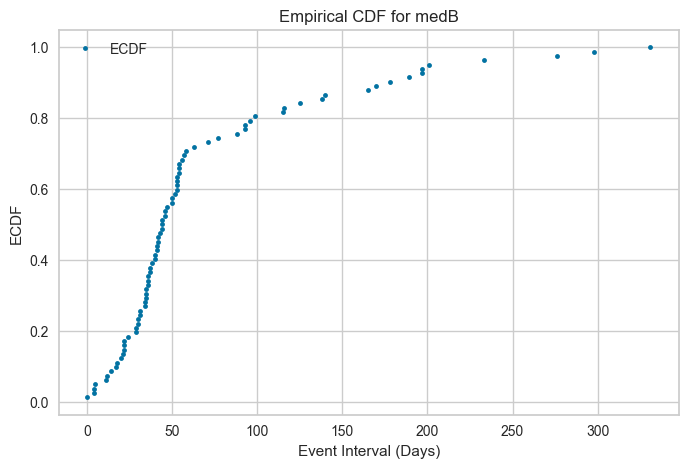

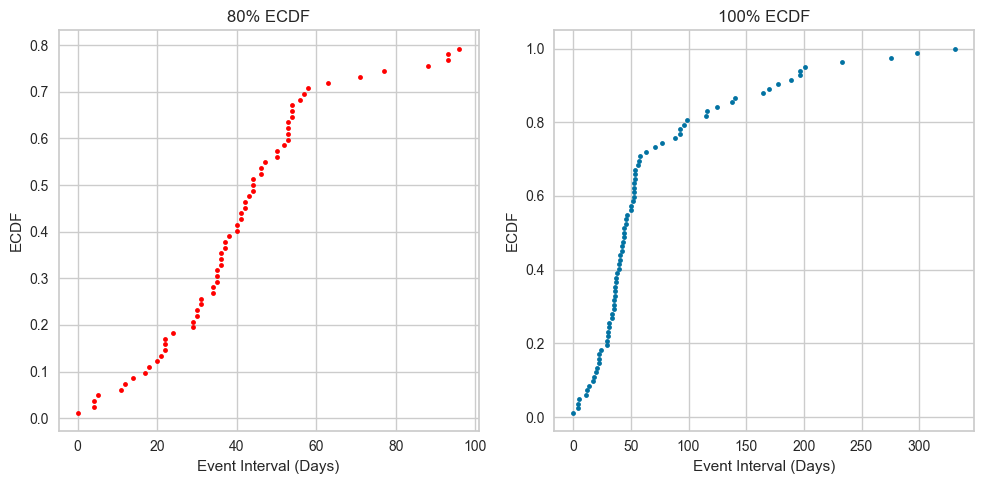

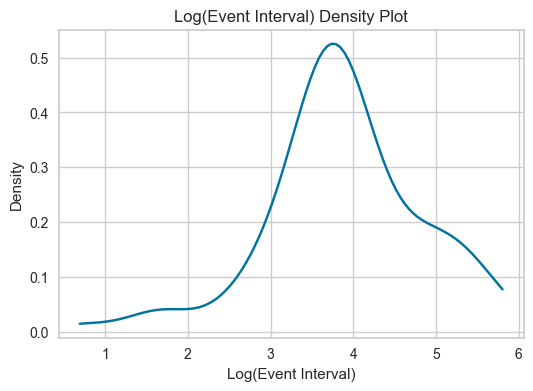

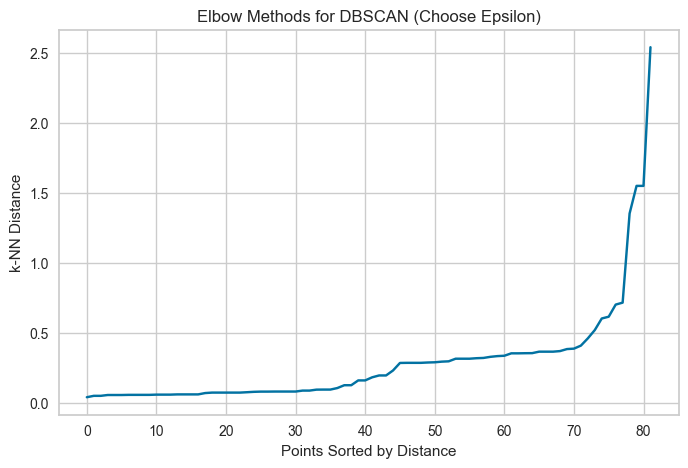

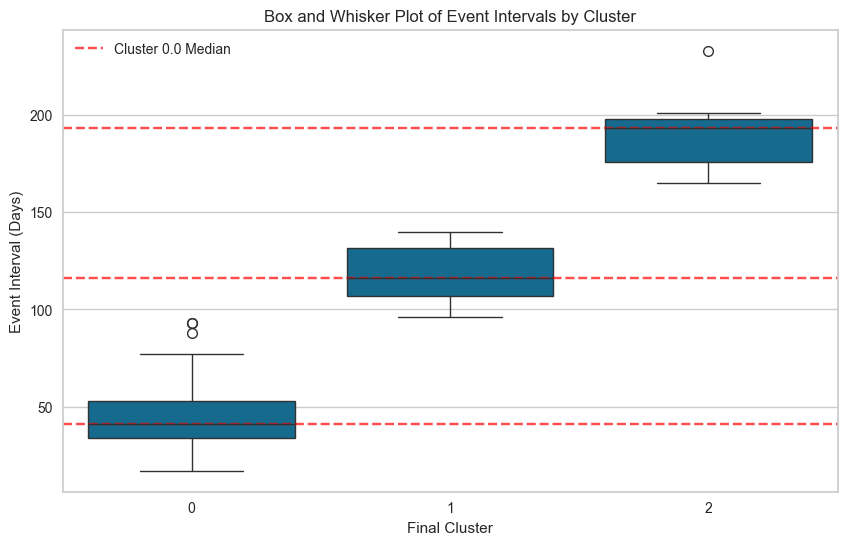

In [ ]:
def load_and_preprocess_data(filepath, med_type):
    df = pd.read_csv(filepath)
    
    df["DATE"] = pd.to_datetime(df["DATE"])
    
    df_filtered = df[df["CATEGORY"] == med_type].copy()
    
    df_filtered = df_filtered.sort_values(by=["PATIENT_ID", "DATE"])
    
    df_filtered["PREV_DATE"] = df_filtered.groupby("PATIENT_ID")["DATE"].shift(1)
    
    df_filtered = df_filtered.dropna(subset=["PREV_DATE"])
    
    df_filtered["EVENT_INTERVAL"] = (df_filtered["DATE"] - df_filtered["PREV_DATE"]).dt.days
    
    df_sampled = df_filtered.groupby("PATIENT_ID").sample(n=1, random_state=42)
    
    return df_sampled

def plot_ecdf(df_sampled, med_type):
    # Compute ECDF
    ecdf = ECDF(df_sampled["EVENT_INTERVAL"])
    df_ecdf = pd.DataFrame({"x": ecdf.x, "y": ecdf.y})
    
    plt.figure(figsize=(8, 5))
    plt.plot(df_ecdf["x"], df_ecdf["y"], marker=".", linestyle="none", label="ECDF")
    plt.xlabel("Event Interval (Days)")
    plt.ylabel("ECDF")
    plt.title(f"Empirical CDF for {med_type}")
    plt.legend()
    plt.show()
    
    # Retain 80% of the ECDF
    df_ecdf_80 = df_ecdf[df_ecdf["y"] <= 0.8]
    ni = df_ecdf["x"].max()
    
    # Plot 80% and 100% ECDF
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(df_ecdf_80["x"], df_ecdf_80["y"], marker=".", linestyle="none", color="red")
    plt.xlabel("Event Interval (Days)")
    plt.ylabel("ECDF")
    plt.title("80% ECDF")
    
    plt.subplot(1, 2, 2)
    plt.plot(df_ecdf["x"], df_ecdf["y"], marker=".", linestyle="none")
    plt.xlabel("Event Interval (Days)")
    plt.ylabel("ECDF")
    plt.title("100% ECDF")
    
    plt.tight_layout()
    plt.show()
    
    return df_ecdf_80, ni

def plot_density(df_filtered, ni):
    df_filtered = df_filtered[df_filtered["EVENT_INTERVAL"] <= ni]
    
    df_filtered["EVENT_INTERVAL"] = df_filtered["EVENT_INTERVAL"].replace(0, 1)
    
    log_intervals = np.log1p(df_filtered["EVENT_INTERVAL"])
    
    density = gaussian_kde(log_intervals)
    x_vals = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    y_vals = density(x_vals)
    
    plt.figure(figsize=(6, 4))
    plt.plot(x_vals, y_vals)
    plt.xlabel("Log(Event Interval)")
    plt.ylabel("Density")
    plt.title("Log(Event Interval) Density Plot")
    plt.show()
    
    return log_intervals

def find_optimal_eps(log_intervals):
    
    scaler = StandardScaler()
    X = scaler.fit_transform(log_intervals.to_numpy().reshape(-1,1))

    neigh = NearestNeighbors(n_neighbors=10)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)

    distances = np.sort(distances[:,-1])
    plt.figure(figsize=(8,5))
    plt.plot(distances)
    plt.xlabel("Points Sorted by Distance")
    plt.ylabel("k-NN Distance")
    plt.title("Elbow Methods for DBSCAN (Choose Epsilon)")
    plt.show()

def assign_clusters_dbscan(df_filtered, log_intervals, eps=0.5, min_samples=3):
    # Convert Series to NumPy array and reshape for clustering
    scaler = StandardScaler()
    X = scaler.fit_transform(log_intervals.to_numpy().reshape(-1,1))
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X)

    df_filtered["Final_Cluster"] = clusters
    df_filtered = df_filtered[df_filtered["Final_Cluster"] != -1]

    return df_filtered

def assign_median_duration(final_df):
    median_refill = final_df.groupby('Final_Cluster')['EVENT_INTERVAL'].median().reset_index()
    median_refill.columns = ['Final_Cluster', 'Median_Refill_Interval']
    final_df = final_df.merge(median_refill, on='Final_Cluster', how='left')
    return final_df

  
def box_and_whisker_plot(final_df):
    plt.figure(figsize=(10, 6))
    
    sns.boxplot(x="Final_Cluster", y="EVENT_INTERVAL", data=final_df, showfliers=True)
    
    median_intervals = final_df.groupby("Final_Cluster")[["Median_Refill_Interval"]].first().reset_index()
    for index, row in median_intervals.iterrows():
        plt.axhline(y=row["Median_Refill_Interval"], color="red", linestyle="--", alpha=0.7, label=f"Cluster {row['Final_Cluster']} Median" if index == 0 else "")
    
    plt.xlabel("Final Cluster")
    plt.ylabel("Event Interval (Days)")
    plt.title("Box and Whisker Plot of Event Intervals by Cluster")
    plt.legend()
    plt.show()

# Main function
def main():
    filepath = "med_events.csv"
    med_type = "medB"
    
    df_sampled = load_and_preprocess_data(filepath, med_type)
    
    df_ecdf_80, ni = plot_ecdf(df_sampled, med_type)
    
    log_intervals = plot_density(df_sampled, ni)
    
    best_k = find_optimal_eps(log_intervals)
    
    df_filtered = assign_clusters_dbscan(df_sampled, log_intervals, eps=0.3, min_samples=10)
    
    df_filtered = assign_median_duration(df_filtered)

    box_and_whisker_plot(df_filtered)

    final_df = df_filtered[["PATIENT_ID", "EVENT_INTERVAL", "Final_Cluster", "Median_Refill_Interval"]]
    return final_df

if __name__ == "__main__":
    final_df = main()
    final_df.to_csv("clustersandduration.csv", index=False)